D:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:20:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


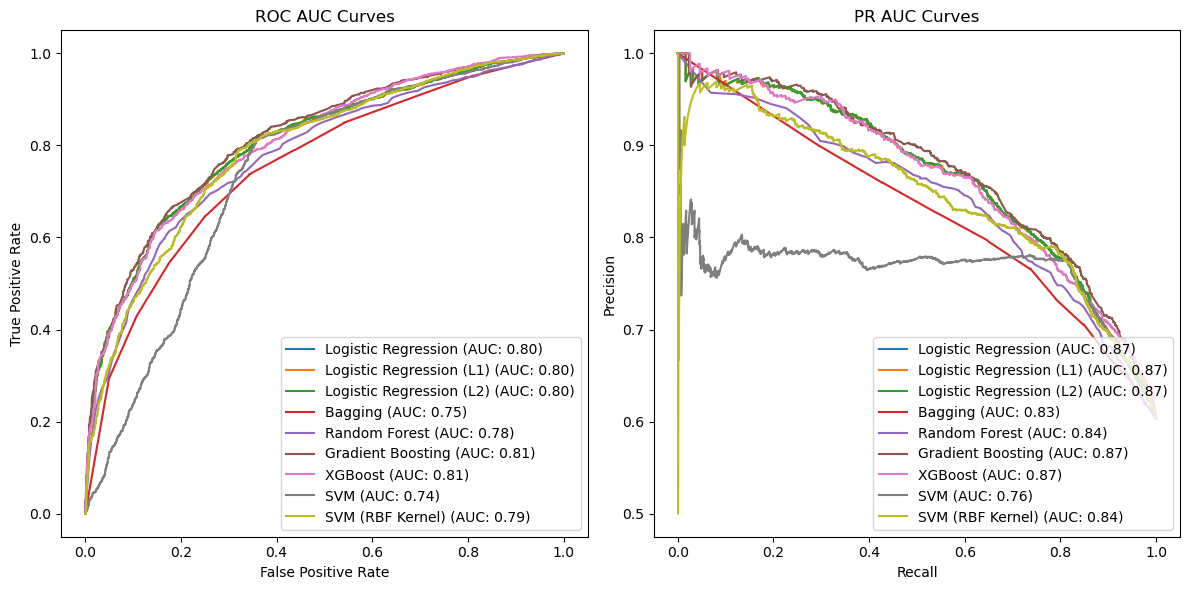

Accuracy Results:
{'Logistic Regression': 0.7444961240310077, 'Logistic Regression (L1)': 0.7444961240310077, 'Logistic Regression (L2)': 0.7444961240310077, 'Bagging': 0.7054263565891473, 'Random Forest': 0.7184496124031008, 'Gradient Boosting': 0.7466666666666667, 'XGBoost': 0.7330232558139534, 'SVM': 0.7438759689922481, 'SVM (RBF Kernel)': 0.7438759689922481}


In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc, classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt

# Load data
plays = pd.read_csv('plays.csv')

# Feature engineering
plays['scoreDifferential'] = plays['preSnapHomeScore'] - plays['preSnapVisitorScore']
plays['isLeading'] = (plays['scoreDifferential'] > 0).astype(int)
plays['isRedZone'] = (plays['absoluteYardlineNumber'] <= 20).astype(int)
plays['shortYardage'] = (plays['yardsToGo'] <= 2).astype(int)
plays['thirdAndLong'] = ((plays['down'] == 3) & (plays['yardsToGo'] > 7)).astype(int)
plays['fourthQuarter'] = (plays['quarter'] == 4).astype(int)
plays['twoMinuteDrill'] = ((plays['quarter'] >= 2) & 
                           (plays['gameClock'].str.split(':').str[0].astype(int) <= 2))
plays['playType'] = plays['passResult'].apply(lambda x: 0 if pd.isnull(x) else 1)

# Select features and target
features = [
    'yardsToGo', 'quarter', 'down', 'expectedPoints', 'scoreDifferential', 'isLeading',
    'isRedZone', 'shortYardage', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill',
    'preSnapHomeScore', 'preSnapVisitorScore', 'offenseFormation'
]
data = plays[features + ['playType']]

# One-hot encode offensive formations
encoder = OneHotEncoder(sparse_output=False)
encoded_formations = encoder.fit_transform(data[['offenseFormation']])
formation_columns = [f'formation_{cat}' for cat in encoder.categories_[0]]
encoded_df = pd.DataFrame(encoded_formations, columns=formation_columns)
data = pd.concat([data.reset_index(drop=True), encoded_df], axis=1).drop(columns=['offenseFormation'])

# Prepare dataset
X = data.drop(columns=['playType'])
y = data['playType']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=28, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=28, stratify=y_train_full)

# Standardizing for some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=28),
    "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, random_state=28),
    "Logistic Regression (L2)": LogisticRegression(penalty='l2', max_iter=500, random_state=28),
    "Bagging": BaggingClassifier(random_state=28),
    "Random Forest": RandomForestClassifier(random_state=28),
    "Gradient Boosting": GradientBoostingClassifier(random_state=28),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=28),
    "SVM": SVC(kernel='linear', probability=True, random_state=28),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=28),
}

# Storage for metrics
accuracy_results = {}
roc_auc_results = {}
pr_auc_results = {}

# Initialize plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("ROC AUC Curves")
plt.subplot(1, 2, 2)
plt.title("PR AUC Curves")

for model_name, model in models.items():
    if "SVM" in model_name:
        model.fit(X_train_scaled, y_train)
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    y_pred = model.predict(X_test_scaled if "SVM" in model_name else X_test)
    accuracy_results[model_name] = accuracy_score(y_test, y_pred)
    
    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    roc_auc_results[model_name] = roc_auc
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC: {roc_auc:.2f})")
    
    # PR AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    pr_auc = auc(recall, precision)
    pr_auc_results[model_name] = pr_auc
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"{model_name} (AUC: {pr_auc:.2f})")

# ROC curve plot formatting
plt.subplot(1, 2, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# PR curve plot formatting
plt.subplot(1, 2, 2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Display results
print("Accuracy Results:")
print(accuracy_results)
